## Regional Satellite / WRF-Chem comparison script

Bulk work, to combine data for each season, rather than plotting a single day at a time.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib import interactive
interactive(True)

import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats
import scipy

from datetime import timedelta, date
import datetime

In [2]:
# date range function from stackoverflow: 
#   https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#   (same source is used for the date range iteration below too)
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [3]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    sat_clcov_data = sat_datadask.CLcov.copy(deep=True)
    sat_angle_data = sat_datadask.angle.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    clcd = sat_clcov_data.to_dataframe()
    angd = sat_angle_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
     
    # load the model data, convert to pandas
    model_nh3_data = model_datadask.nh3.copy(deep=True)
    model_date_data = model_datadask.date.copy(deep=True)
    nh3d = model_nh3_data.to_dataframe()
    dat_temp_d = model_date_data.to_dataframe()
    #dat_temp_d.column = ['full_date']
    
    # FUTURE WORK: split the date information into date and hour
    #date2d = dat_temp_d.datetime.strftime('%m/%d/%Y')
    #date2d.column = ['date']
    #hour2d = dat_temp_d.datetime.strftime('%H:%M:%S.%f')
    #hour2d.column = ['time_of_day']
    
    #result_temp = pd.concat([nh3d,dated,hourd,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    result_temp = pd.concat([dat_temp_d,nh3d,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    
    # switch index from time to date
    result = result_temp.reset_index(drop=False).set_index(['date','latitude','longitude'])

    return result

In [4]:
# Loading data files from a list.
def load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date):
    
    # initalise list for storing datasets to append
    data_to_append = []  # https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

    for single_date in daterange(start_date, end_date):
        
        date_string = single_date.strftime("%Y%m%d")+'_*'
        satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
        model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')
        
        # load data for the given day
        day_data = load_create_dataframe(satellite_datadask,model_datadask)
        # get rid of empty data points, to save space!
        clean_day_data = day_data.dropna()
        
        # store DataFrame in list
        data_to_append.append(clean_day_data)
    
    
    appended_data = pd.concat(data_to_append, axis=0)
    
    return(appended_data)
    

#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [5]:
root_path = '/Users/mbessdl2/Documents/Clearflo_data_analysis/'
satellite_file_path = root_path+'satellite_data/'
model_file_path = root_path+'model_column_data/'

# summer
start_date = date(2012, 7, 30)
end_date = date(2012, 8, 23)
#start_date = date(2012, 8, 19)
#end_date = date(2012, 8, 20)
# winter
#start_date = date(2012, 1, 8)
#end_date = date(2012, 2, 11)



In [6]:
work_data = load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: Fu

In [7]:
#work_data['date2'] = work_data['date'].dt.strftime('%m/%d/%Y')
#work_data['hour2'] = work_data['date'].dt.strftime('%H:%M:%S.%f')

#df.loc[('bar', 'two'),]
#work_data.hour2.values

#work_data2 = work_data.rename(columns={'nh3':'model', 'column':'satellite'})
work_data2 = work_data.sort_values(by='column',ascending=False)

work_data3 = work_data.reset_index()

work_data3

,date,latitude,longitude,time,nh3,column,error,VertProf,CLcov,angle
0,2012-07-31 08:30:36.999892992,59.045609,13.389850,83037.179688,3.803935e+15,2.986267e+15,101.717888,0,0.000000,53.820000
1,2012-07-31 08:30:36.999892992,58.799381,13.343570,83037.179688,3.413113e+15,4.437199e+14,683.670471,0,0.000000,53.820000
2,2012-07-31 08:30:44.999313408,58.539120,14.076880,83045.171875,2.672602e+15,1.793506e+15,284.811798,1,0.000000,52.180000
3,2012-07-31 08:30:52.998733824,57.942299,10.830850,83053.390625,1.480850e+15,1.023774e+15,279.330017,0,24.469999,58.400002
4,2012-07-31 08:31:00.998153216,57.750160,10.816420,83101.398438,2.058041e+15,6.232397e+14,501.588898,0,12.390000,58.389999
5,2012-07-31 08:31:00.998153216,57.713150,11.733120,83101.398438,2.105702e+15,5.300686e+15,118.549088,1,14.920000,56.680000
6,2012-07-31 08:31:08.997573632,57.019150,10.731670,83109.390625,3.217821e+15,-1.838173e+14,1553.609619,0,0.000000,58.400002
7,2012-07-31 08:31:24.999846912,56.016720,12.860520,83125.179688,3.741633e+15,1.496492e+15,305.801331,1,0.000000,53.820000
8,2012-07-31 08:31:32.999267328,55.798618,12.826310,83133.179688,3.755298e+15,3.036590e+15,196.228210,1,0.000000,53.810001
9,2012-07-31 08:31:32.999267328,55.900291,10.610560,83133.398438,1.898301e+15,3.954926e+15,216.695831,1,10.410000,58.389999


In [8]:
work_data.error.mean()

1542.21337890625

### Data cleaning and sorting

Cleaning:
* I drop any NaN's in the data (both to zoom into the model domain, as work_data.nh3 will be NaN outside of this, and to get rid of the missing values in the satellite data, where work_data.column is a NaN). For the bulk processing of data this has already been applied as the data is loaded.
* I also get rid of the negative satellite values (simply by locating all lines where column > 0.0)

Sorting.

Main categories:
* cd_all:  all co-located model/satellite data
* cd_land: all retrievals flagged as land-based
* cd_sea:  all retrievals flagged as sea-based
* cd_high: satellite zenith angles < 10 degrees
* cd_low:  satellite zenith angles > 45 degrees

Combined categories:
* cd_sea_low
* cd_sea_high
* cd_land_low
* cd_land_high

In [9]:
clean_data_extra = work_data.loc[work_data['column']>0.0]
#cd2 = clean_data_extra.reset_index()
#cd_all = cd2.set_index(['VertProf','time'])
#cd_land = cd_all.loc(axis=0)[1]
#cd_sea  = cd_all.loc(axis=0)[0]
#cd_all  = work_data 
cd_all  = clean_data_extra
cd_land = cd_all.loc[cd_all['VertProf']==1]
cd_sea  = cd_all.loc[cd_all['VertProf']==0]
cd_high = cd_all.loc[cd_all['angle']<10]
cd_low  = cd_all.loc[cd_all['angle']>45]

cd_sea_high = cd_sea.loc[cd_sea['angle']<10]
cd_land_high = cd_land.loc[cd_land['angle']<10]
cd_sea_low = cd_sea.loc[cd_sea['angle']>45]
cd_land_low = cd_land.loc[cd_land['angle']>45]


cd_centre = work_data3.loc[work_data3['latitude']>45].loc[work_data3['latitude']<62] \
            .loc[work_data3['longitude']>-13].loc[work_data3['longitude']<8]

In [10]:
def stat_report_basic(dataset,dataname):
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset.column,dataset.nh3)
    print("For ",dataname)
    print("  count is:", dataset.column.count())
    print("  slope is:", slope)
    print("  r-squared:", r_value**2)
    
def simple_func(x, a, b):
    return a * x + b    

def stat_report(dataset,dataname):
    #
    # There's a problem/bug in curve_fit when using float32 data - as a work around convert to float64,
    #      using .astype(np.float64)
    #
    # Perhaps, in future, this will be fixed - then this code can be simplified again.
    # https://github.com/scipy/scipy/issues/7117
    #
    
    # this curve fit gives the same result as the stats.linregress function
    popt, pcov = scipy.optimize.curve_fit(simple_func,dataset.column.astype(np.float64),dataset.nh3.astype(np.float64))
    # as above, but with weighting according to the error information (low error, more weight, I think...)
    popt_w, pcov_w = scipy.optimize.curve_fit(simple_func,dataset.column.astype(np.float64),dataset.nh3.astype(np.float64),sigma=dataset.error.astype(np.float64),absolute_sigma=False)
    
    # calculation of one standard deviation error for the fits above  
    perr = np.sqrt(np.diag(pcov))
    perr_w = np.sqrt(np.diag(pcov_w))
    
    # Spearman's Rank Correlation calculation
    sp_corr = stats.spearmanr(dataset.column,dataset.nh3)
    
    
    print("For ",dataname)
    print("  count is:", dataset.column.count())
    print("  slope is:", popt[0],"  with std dev error: ", perr[0])
    print("  intercept is:", popt[1],"  with std dev error: ", perr[1])

    print(" Weighted by satellite errors:")
    print("  slope is:", popt_w[0],"  with std dev error: ", perr_w[0])
    print("  intercept is:", popt_w[1],"  with std dev error: ", perr_w[1])
    
    print(" Spearman's Rank Correlation: ",sp_corr.correlation)
    print(" p-value: ", sp_corr.pvalue)

    

In [11]:
stat_report(work_data,"clean_data, with negative values")
stat_report(cd_all,"cd_all, without negative values")
stat_report(cd_land,"cd_land")
stat_report(cd_sea,"cd_sea")
stat_report(cd_high,"cd_high")
stat_report(cd_low,"cd_low")
stat_report(cd_sea_high,"cd_sea_high")
stat_report(cd_sea_low,"cd_sea_low")
stat_report(cd_land_high,"cd_land_high")
stat_report(cd_land_low,"cd_land_low")
stat_report(cd_centre,"cd_centre")

For  clean_data, with negative values
  count is: 55049
  slope is: 0.2228994754954664   with std dev error:  0.0020426545270414206
  intercept is: 2342426112188607.0   with std dev error:  20050512448152.76
 Weighted by satellite errors:
  slope is: 0.563177787357889   with std dev error:  0.002977289790468949
  intercept is: 615289591.9762517   with std dev error:  60069507127682.56
 Spearman's Rank Correlation:  0.3377540190810951
 p-value:  0.0
For  cd_all, without negative values
  count is: 33188
  slope is: 0.30095895236236947   with std dev error:  0.003273242744400241
  intercept is: 1500381853575006.8   with std dev error:  38471299578946.23
 Weighted by satellite errors:
  slope is: 0.5820080449426501   with std dev error:  0.004044739691000994
  intercept is: 583893496.4606988   with std dev error:  69911058501905.57
 Spearman's Rank Correlation:  0.4220516147148924
 p-value:  0.0
For  cd_land
  count is: 15725
  slope is: 0.27260177474805897   with std dev error:  0.004807

### Data plotting

Plotting of model vs satellite relationship, for the subgroups defined above.

First set of plots is without weighting by the satellite errors, second set of plots is with this weighting.

In each plot the linear correlation line is given, along with dashed lines indicating the bounds of the one standard deviation uncertainty in slope and intercept.



In [48]:
def upper_lower_bounds(xline,slope,intercept,slope_error,intercept_error):
    s1 = slope + slope_error
    s2 = slope - slope_error
    
    i1 = intercept + intercept_error
    i2 = intercept - intercept_error
    
    line_a = s1*xline+i1
    line_b = s2*xline+i2
    line_c = s1*xline+i2
    line_d = s2*xline+i1

    line_data = slope*xline+intercept
 
    line_upper = np.max([line_a,line_b,line_c,line_d,line_data],axis=0)
    line_lower = np.min([line_a,line_b,line_c,line_d,line_data],axis=0)
    
    return line_upper, line_lower


def nh3_plot(cd_plot,ax,titlestring,weighted):

    xline = np.array([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])*1e17

    #slope, intercept, r_value, p_value, std_err = stats.linregress(cd_plot.column,cd_plot.nh3)

    if(weighted):
        # as below, but with weighting according to the error information (low error, more weight, I think...)
        popt, pcov = scipy.optimize.curve_fit(simple_func,cd_plot.column.astype(np.float64),cd_plot.nh3.astype(np.float64),sigma=cd_plot.error.astype(np.float64),absolute_sigma=False)
    else:
        # this curve fit gives the same result as the stats.linregress function
        popt, pcov = scipy.optimize.curve_fit(simple_func,cd_plot.column.astype(np.float64),cd_plot.nh3.astype(np.float64))
    
    # calculation of one standard deviation error for the fits above  
    perr = np.sqrt(np.diag(pcov))
    
    # slope for standard fit
    slope = popt[0]
    intercept = popt[1]
    line = slope*xline+intercept

    # determine the bounds of uncertainty for the lines
    line_upper, line_lower = upper_lower_bounds(xline,slope,intercept,perr[0],perr[1])
    
 
    ax.plot(cd_plot.column, cd_plot.nh3, 'o', xline, line, '-', xline, line_upper, 'g--', xline, line_lower, 'g--')
    ax.set_title(titlestring)
    ax.set_xlim(-0.5e17,1e17)
    ax.set_ylim(-0.5e17,1e17)


def nh3_plot_alt(cd_plot,ax,titlestring):

    xline = np.array([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])*1e17

    #slope, intercept, r_value, p_value, std_err = stats.linregress(cd_plot.column,cd_plot.nh3)

    ## weighted
    # as below, but with weighting according to the error information (low error, more weight, I think...)
    popt_w, pcov_w = scipy.optimize.curve_fit(simple_func,cd_plot.column.astype(np.float64),cd_plot.nh3.astype(np.float64),sigma=cd_plot.error.astype(np.float64),absolute_sigma=False)
    ## non-weighted
    # this curve fit gives the same result as the stats.linregress function
    popt_nw, pcov_nw = scipy.optimize.curve_fit(simple_func,cd_plot.column.astype(np.float64),cd_plot.nh3.astype(np.float64))
    

    # slope for standard fit
    slope_w = popt_w[0]
    intercept_w = popt_w[1]
    line_w = slope_w*xline+intercept_w
    # slope for standard fit
    slope_nw = popt_nw[0]
    intercept_nw = popt_nw[1]
    line_nw = slope_nw*xline+intercept_nw

    xedges = np.arange(-6e16,12e16,0.1e16)
    yedges = xedges
    
    # setup information for the histogram
    H, xedges, yedges = np.histogram2d(cd_plot.column, cd_plot.nh3, bins=(xedges, yedges))
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)
    
    
    
    ax.pcolormesh(X, Y, np.log10(H))
    ax.plot(xline, line_w, xline, line_nw)
    ax.set_title(titlestring)
    ax.set_xlim(-0.5e17,1e17)
    ax.set_ylim(-0.5e17,1e17)



    
def nh3_diff_hist(cd_plot,bhist,ax,titlestring):
    
    ax.hist(cd_plot.column-cd_plot.nh3,bins=bhist,rwidth=0.9,log=True)
    ax.set_title(titlestring)

    
   

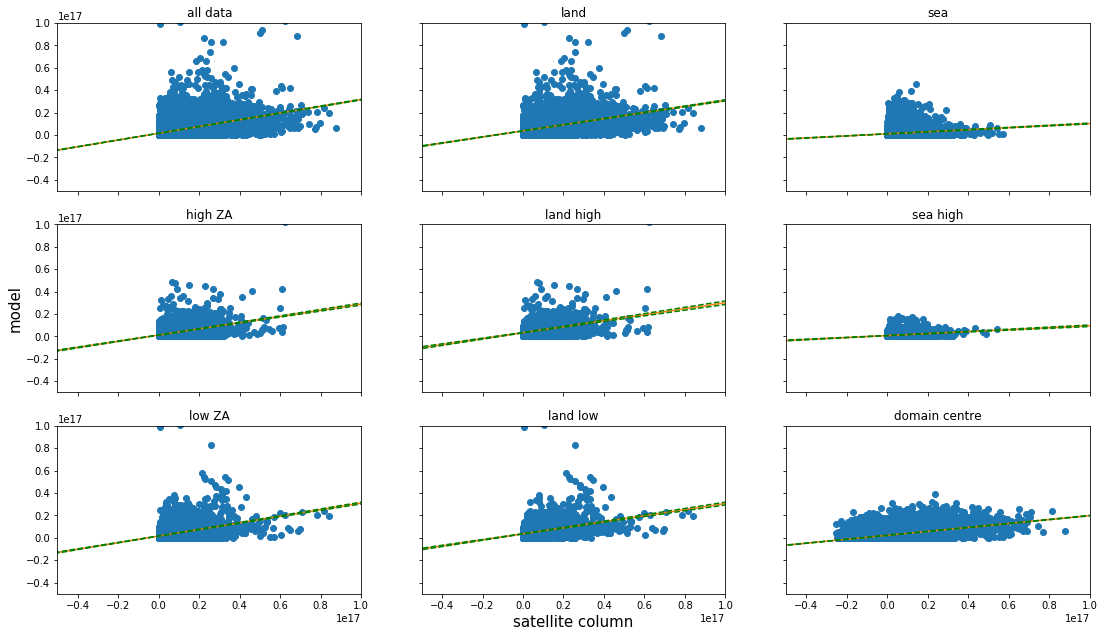

In [13]:
fig, axes = plt.subplots(3, 3, sharex='all', sharey='all')
fig.set_size_inches(18.5, 10.5)
axes[2,1].set_xlabel(r'satellite column', fontsize=15)
axes[1,0].set_ylabel(r'model', fontsize=15)

weighted = False

nh3_plot(cd_all,axes[0,0],"all data",weighted)
nh3_plot(cd_land,axes[0,1],"land",weighted)
nh3_plot(cd_sea,axes[0,2],"sea",weighted)

nh3_plot(cd_high,axes[1,0],"high ZA",weighted)
nh3_plot(cd_low,axes[2,0],"low ZA",weighted)

nh3_plot(cd_land_high,axes[1,1],"land high",weighted)
nh3_plot(cd_sea_high,axes[1,2],"sea high",weighted)

nh3_plot(cd_land_low,axes[2,1],"land low",weighted)
#nh3_plot(cd_sea_low,axes[2,2],"sea low",weighted)
nh3_plot(cd_centre,axes[2,2],"domain centre",weighted)

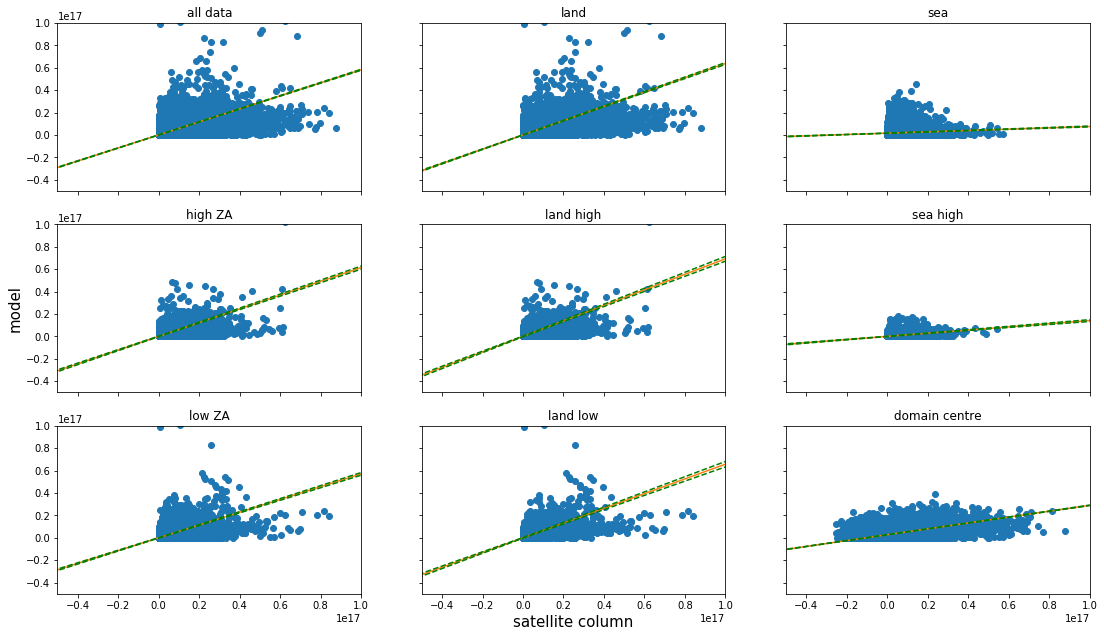

In [14]:
fig, axes = plt.subplots(3, 3, sharex='all', sharey='all')
fig.set_size_inches(18.5, 10.5)
axes[2,1].set_xlabel(r'satellite column', fontsize=15)
axes[1,0].set_ylabel(r'model', fontsize=15)

weighted = True

nh3_plot(cd_all,axes[0,0],"all data",weighted)
nh3_plot(cd_land,axes[0,1],"land",weighted)
nh3_plot(cd_sea,axes[0,2],"sea",weighted)

nh3_plot(cd_high,axes[1,0],"high ZA",weighted)
nh3_plot(cd_low,axes[2,0],"low ZA",weighted)

nh3_plot(cd_land_high,axes[1,1],"land high",weighted)
nh3_plot(cd_sea_high,axes[1,2],"sea high",weighted)

nh3_plot(cd_land_low,axes[2,1],"land low",weighted)
#nh3_plot(cd_sea_low,axes[2,2],"sea low",weighted)
nh3_plot(cd_centre,axes[2,2],"domain centre",weighted)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10


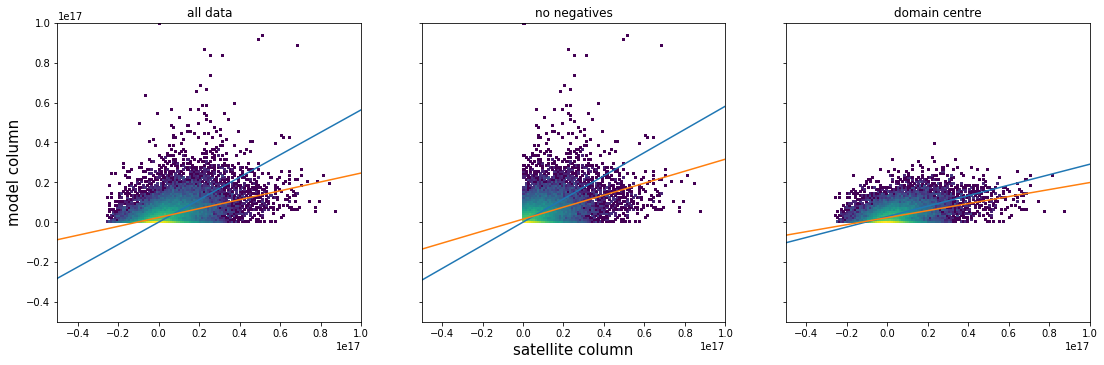

In [32]:
fig, axes = plt.subplots(1, 3, sharex='all', sharey='all')
fig.set_size_inches(18.5, 5.5)
axes[1].set_xlabel(r'satellite column', fontsize=15)
axes[0].set_ylabel(r'model column', fontsize=15)

nh3_plot_alt(work_data,axes[0],"all data")
nh3_plot_alt(cd_all,axes[1],"no negatives")
nh3_plot_alt(cd_centre,axes[2],"domain centre")

(array([ 4289., 14180., 10728.,  6092.,  3822.,  2561.,  3364.,  1989.,
         1329.,  1639.,  1000.]),
 array([   0,   50,  100,  150,  200,  250,  300,  400,  500,  600,  800,
        1000]),
 <a list of 11 Patch objects>)

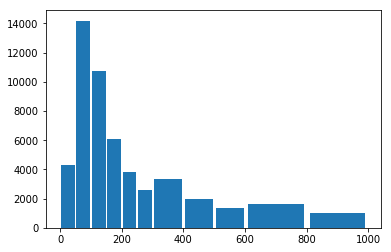

In [33]:
#plt.hist(work_data.error, bins=[0,40,80,160,500,1000,work_data.error.max()],rwidth=0.5)
plt.hist(work_data.error, bins=[0,50,100,150,200,250,300,400,500,600,800,1000], range=[0,1000],rwidth=0.9,log=False)

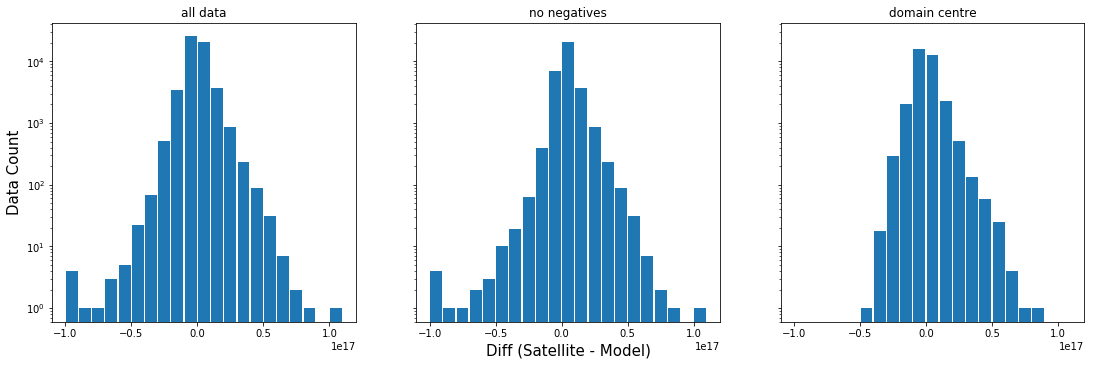

In [49]:
bhist = np.arange(-1e17,1.2e17,1e16) # setting the range of the histogram

fig, axes = plt.subplots(1, 3, sharex='all', sharey='all')
fig.set_size_inches(18.5, 5.5)
axes[1].set_xlabel(r'Diff (Satellite - Model)', fontsize=15)
axes[0].set_ylabel(r'Data Count', fontsize=15)

nh3_diff_hist(work_data,bhist,axes[0],"all data")
nh3_diff_hist(cd_all,bhist,axes[1],"no negatives")
nh3_diff_hist(cd_centre,bhist,axes[2],"domain centre")

In [ ]:
#stats.weightedtau?
#stats.theilslopes?
#stats.kendalltau?
#stats.spearmanr?
scipy.optimize.curve_fit?

In [42]:
plt.hist?